In [1]:
__author__ = "Lisette Espin"
__copyright__ = "Copyright 2019, GESIS / USC-ISI"
__credits__ = ["Lisette Espin-Noboa", 
               "Fariba Karimi",                
               "Claudia Wagner",
               "Markus Strohmaier"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Lisette Espin"
__email__ = "lisette.espin@gesis.org"
__status__ = "Development"

<h1>Model Fitting</h1>

In [2]:
%load_ext autoreload
%autoreload 2

from org.gesis.model.graph import DirectedGraph
from org.gesis.model.graph import get_homophily
from org.gesis.libs.utils import printf
import networkx as nx
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
from org.gesis.model.DHBA import estimate_homophily_empirical
from org.gesis.libs import utils
import networkx as nx
import operator
from collections import defaultdict
import numpy as np
import ast
from joblib import Parallel, delayed

In [3]:
DATASETS = ['aps','github','pokec','wikipedia'] #'twitter'
ROOT = '../data/'
OUTPUT = "../results-batch/"

In [4]:
fn = os.path.join(OUTPUT, 'summary_datasets.csv')
df_summary = pd.read_csv(fn, index_col=0)
df_summary

,dataset,N,cc,class,m,M,fm,kmin,E,Emm,EMM,EmM,EMm,density,gammaM,gammam,hMM,hmm,triadsratio,triadspdf
0,APS,1853,173,pacs,05.20.-y,05.30.-d,0.38,1,3638,0.294,0.650,0.027,0.029,0.00106,1.707345,1.781341,0.93,0.95,7.741234e-07,"[0.0, 0.2602935911206588, 0.0, 0.6942355889724..."
1,Github,296612,6965,gender,female,male,0.06,1,1723930,0.005,0.899,0.046,0.051,0.00002,1.595292,1.640447,0.50,0.65,2.551588e-10,"[0.00012062479001814398, 0.0006425589775966516..."
2,Pokec,1632636,1,gender,1,0,0.49,1,30622117,0.195,0.250,0.307,0.248,0.00001,1.373870,1.369903,0.48,0.41,2.853004e-11,"[0.043744452862550076, 0.0685444396945499, 0.0..."
3,Wikipedia,3159,66,gender,female,male,0.15,1,14890,0.030,0.785,0.107,0.078,0.00149,1.518899,1.532553,0.62,0.63,1.416910e-06,"[0.0009691331104327179, 0.0026166593981683385,..."


<h2>Ranking</h2>

In [5]:

PERCENTAGE_RANGE = np.append([5],np.arange(10,100+10,10)).astype(np.float)

def _rank(rank_dict):
    x_list = [] ; y_list = []
    N = len(rank_dict.keys())
    
    for percentage in PERCENTAGE_RANGE:        
        rank = percentage / 100.
        
        x_list.append(percentage)
        count_min = 0
        count_maj = 0
        
        for rank_index in sorted(rank_dict.keys(), reverse = False):
            count_min += rank_dict[rank_index].count('min')
            count_maj += rank_dict[rank_index].count('maj')
            if int(rank_index) > (rank * N):
                break

        y_list.append(float(count_min) / (count_min + count_maj))
    return x_list , y_list

def rank_function_graph(G, metric, minority=None):
    
    if metric == 'degree':
        rank = dict(G.degree())
    elif metric == 'indegree':
        rank = dict(G.in_degree())
    elif metric == 'outdegree':
        rank = dict(G.out_degree())
    elif metric == 'pagerank':
        rank = nx.pagerank(G)
    elif metric == 'adamic-adar-in':
        rank = adamic_adar_rank(G,'in')
    elif metric == 'adamic-adar-out':
        rank = adamic_adar_rank(G,'out')    
    else:
        raise ValueError('metric does not exist: {}'.format(metric)) 
        
    sorted_rnk = sorted(rank.items(), key=operator.itemgetter(1) , reverse = True)
    del(rank)
    
    rank_index = 0
    rank_val = 0
    rank_index_dict = {}
    rank_dict = defaultdict(list)
    count_all_min = 0 ; count_all_maj = 0
    
    for node_index , _val in sorted_rnk:

        if _val in rank_index_dict.keys():
            rank_val = rank_index_dict[_val]
        else:
            rank_val += 1
            rank_index_dict[_val] = rank_val

        try:
            node_color = G.node[node_index][G.graph['class']]
        except:
            try:
                node_color = G.node[node_index][G.graph['label'][0]]
            except Exception as e:
                printf(ValueError("error: {}".format(e)))
                return (None,None),None
        
        node_color = str(node_color)       
        
        if minority is None:
            if node_color in ['min','red','minority','1',1,True]:
                count_all_min += 1
                rank_dict[rank_val].append('min')
            else:
                count_all_maj += 1
                rank_dict[rank_val].append('maj')
        else:
            if node_color == str(minority):
                count_all_min += 1
                rank_dict[rank_val].append('min')
            else:
                count_all_maj += 1
                rank_dict[rank_val].append('maj')
            
    minority_fraction = float(count_all_min) /float(count_all_min+count_all_maj)
    return _rank(rank_dict),minority_fraction

<h3>Empirical</h3>

In [6]:
fn = 'tmp_rank_empirical.csv'
fn = os.path.join(OUTPUT,fn)

In [11]:
if os.path.exists(fn):
    df_rank_empirical = pd.read_csv(fn, index_col=0)
else:
    cols = ['kind','dataset','rank','fmt']
    df_rank_empirical = pd.DataFrame(columns=cols)

    for dataset in DATASETS:
        fn = os.path.join(ROOT, dataset, '{}_attributed_network_anon.gpickle'.format(dataset))
        graph = nx.read_gpickle(fn)
        (rank, fmt), minority_fraction = rank_function_graph(graph,'pagerank')
        df_rank_empirical = df_rank_empirical.append(pd.DataFrame({'kind':'empirical', 
                                                                   'dataset':dataset, 
                                                                   'rank':rank, 
                                                                   'fmt':fmt},columns=cols), ignore_index=True)    
    df_rank_empirical.to_csv(fn)

In [12]:
df_rank_empirical.head()

,kind,dataset,rank,fmt
0,empirical,aps,5.0,0.454545
1,empirical,aps,10.0,0.409091
2,empirical,aps,20.0,0.407692
3,empirical,aps,30.0,0.378788
4,empirical,aps,40.0,0.355805


<h3>Synthetic</h3>

In [13]:
def create(index,row,epoch,model,N):
    if __name__ == '__main__':
        pass
    
    cols = ['kind','dataset','rank','fmt']
    
    dataset = row.dataset.lower()      
    density = row.density

    #density = N * row.density / row.N # wrong?
    #print(row.triadsratio)
    #print(row.triadspdf)
    #print(sum(ast.literal_eval(row.triadspdf)))

    DG = DirectedGraph(model,
                       N=N,
                       kmin=row.kmin,
                       density=density,
                       #density=N*row.E/row.N,
                       minority_fraction=row.fm,
                       gamma_m=row.gammam,
                       gamma_M=row.gammaM,
                       h_mm=row.hmm,
                       h_MM=row.hMM,
                       triads_ratio=row.triadsratio,
                       triads_pdf=ast.literal_eval(row.triadspdf))
    DG.create_network()
    DG.G.graph['dataset'] = dataset

    DG.info()
    # beta_M, sig_M, beta_m, sig_m = utils.get_indegree_powerlaw_exponents(DG.G)
    # print(estimate_homophily_empirical(DG.G, betam=beta_m, betaM=beta_M))
    # print(estimate_homophily_empirical(DG.G))
    # print(nx.density(DG.G))
    # print(DG.G.number_of_nodes())
    # print(DG.G.number_of_edges())
    # print(DG.G.graph)
        
    (rank, fmt), minority_fraction = rank_function_graph(DG.G,'pagerank')
    minority_fraction
    return pd.DataFrame({'kind':model, 
                       'dataset':dataset, 
                       'rank':rank,
                       'fmt':fmt},columns=cols)
    
        

In [14]:
if __name__ == '__main__':
    pass

model = 'DHBA'
N = 2000
num_cores = 40
results = Parallel(n_jobs=num_cores)(delayed(create)(index,row,epoch,model,N) 
                                     for index,row in df_summary.iterrows() 
                                     for epoch in np.arange(5))
df_rank_synthetic = pd.concat(results)

density: 0.00106
density: 0.00106
EXPECTED_E: 4238
density: 0.00106
EXPECTED_E: 4238
ADD_NEW_EDGES (y): 1
ADD_NEW_EDGES (y): 1
EXPECTED_E: 4238
START (x): 20
START (x): 20
density: 0.00106
EXPECTED_E: 4238
density: 0.00106
ADD_NEW_EDGES (y): 1
ADD_NEW_EDGES (y): 1
EXPECTED_E: 4238
START (x): 20
ADD_NEW_EDGES (y): 1
START (x): 20
density: 2e-05
density: 2e-05
EXPECTED_E: 80
EXPECTED_E: 80
ADD_NEW_EDGES (y): 1
ADD_NEW_EDGES (y): 1
density: 2e-05
START (x): 20
START (x): 20
EXPECTED_E: 80
START (x): 20
density: 2e-05
ADD_NEW_EDGES (y): 1
START (x): 20
EXPECTED_E: 80
ADD_NEW_EDGES (y): 1
density: 2e-05
START (x): 20
EXPECTED_E: 80
ADD_NEW_EDGES (y): 1
START (x): 20
density: 1e-05
EXPECTED_E: 40
density: 1e-05
ADD_NEW_EDGES (y): 1
EXPECTED_E: 40
START (x): 20
ADD_NEW_EDGES (y): 1
density: 1e-05
START (x): 20
EXPECTED_E: 40
ADD_NEW_EDGES (y): 1
density: 1e-05
START (x): 20
EXPECTED_E: 40
ADD_NEW_EDGES (y): 1
density: 1e-05
START (x): 20
EXPECTED_E: 40
ADD_NEW_EDGES (y): 1
density: 0.00149
ST

Average out degree:   1.9890
{'name': 'DHBA', 'fm': 0.38, 'gamma_M': 1.7073448449373243, 'minority': 'red', 'labels': ['blue', 'red'], 'h_mm': 0.95, 'seed': None, 'N': 2000, 'dataset': 'aps', 'h_MM': 0.93, 'density': 0.00106, 'gamma_m': 1.78134085714817, 'class': 'color', 'kmin': 1, 'groups': ['M', 'm']}

created in 24.683128356933594 seconds.
8043 times, an edge was not inserted

Name: DHBA
Type: DiGraph
Number of nodes: 2000
Number of edges: 5957
Average in degree:   2.9785
Average out degree:   2.9785
{'name': 'DHBA', 'fm': 0.15, 'gamma_M': 1.5188986092805865, 'minority': 'red', 'labels': ['blue', 'red'], 'h_mm': 0.63, 'seed': None, 'N': 2000, 'dataset': 'wikipedia', 'h_MM': 0.62, 'density': 0.00149, 'gamma_m': 1.5325530308485031, 'class': 'color', 'kmin': 1, 'groups': ['M', 'm']}

created in 32.61993670463562 seconds.
12711 times, an edge was not inserted

Name: DHBA
Type: DiGraph
Number of nodes: 2000
Number of edges: 5957
Average in degree:   2.9785
Average out degree:   2.9785
{

In [15]:
by = 'density'
fn = 'tmp_rank_model_by_{}.csv'.format(by)
df_rank_synthetic.to_csv(os.path.join(OUTPUT,fn))

In [16]:
df_rank = df_rank_empirical.copy()
df_rank = df_rank.append(df_rank_synthetic, ignore_index=True)
fn = 'tmp_rank_empirical_vs_model_by_{}.csv'.format(by)
df_rank.to_csv(os.path.join(OUTPUT,fn))

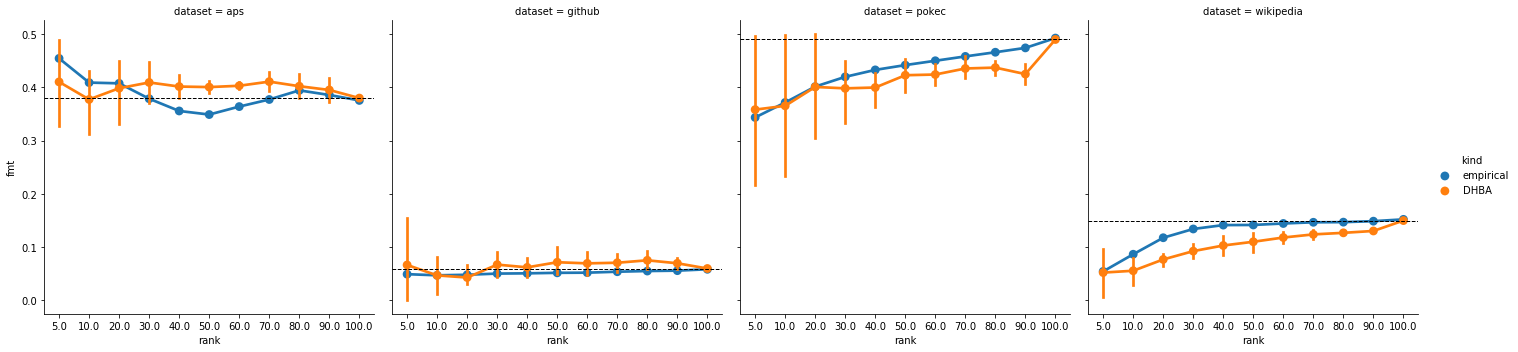

In [17]:
fg = sns.catplot(data=df_rank, col='dataset', hue='kind', x='rank', y='fmt', kind='point')
for ax in fg.axes.flatten():
    dataset= ax.get_title().split(" = ")[-1]
    minority_fraction = df_summary.query("dataset.str.lower()==@dataset").fm.mean()
    ax.axhline(minority_fraction, lw=1, c='black', ls='--')

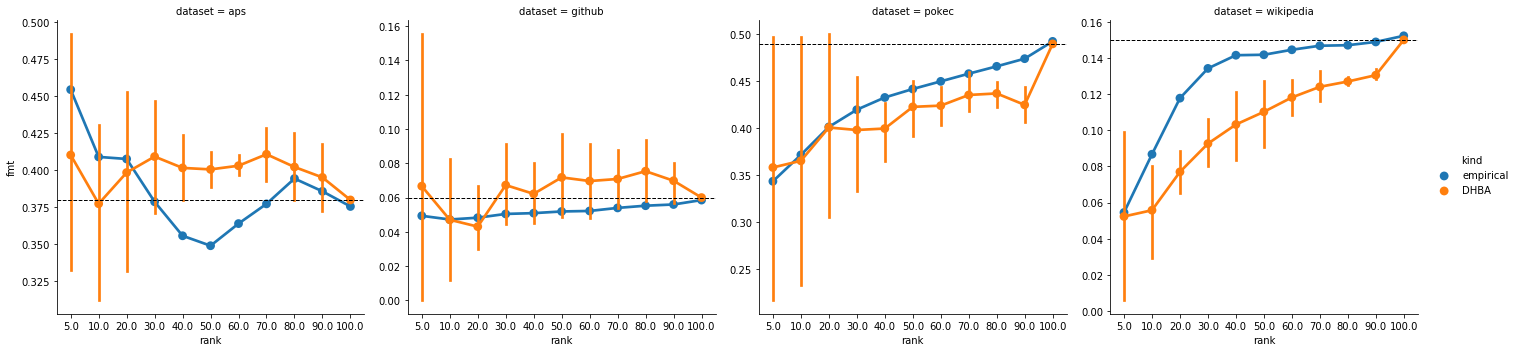

In [18]:
fg = sns.catplot(data=df_rank, col='dataset', hue='kind', x='rank', y='fmt', kind='point',sharey=False)
for ax in fg.axes.flatten():
    dataset= ax.get_title().split(" = ")[-1]
    minority_fraction = df_summary.query("dataset.str.lower()==@dataset").fm.mean()
    ax.axhline(minority_fraction, lw=1, c='black', ls='--')